In [46]:
from matplotlib import pyplot as plt
plt.rc('axes', titlesize=16) #fontsize of the title
plt.rc('legend', fontsize=16) #fontsize of the legend

import numpy as np
from scipy.stats import expon
import pandas as pd

import sys

sys.path.insert(1,'../src')

from BayersianModel import BayersianModel
from Prior import Prior
from MCMC import NaiveSampler
from models import ChemicalReactionNetwork

from copy import deepcopy
from time import time

# Parameters

## the Gilespe simulation of hydrogens

- $k_1$: binding reaction rate
- $k_2$: breaking reaction rate
- $N_H$: number of $H$
- $N_{H_2}$: number of $H_2$
- $T$: total time of simulation

## parameters for inference

- n_observation
- k1_range
- k2_range
- box_size

In [47]:
k1 = 1
k2 = 2
theta = np.array([k1,k2])
NH = 6
NH2 = 2
X_init =  np.array([NH,NH2])
T = 20

reactions = [
    ({'H':2}, {'H2':1}),
    ({"H2":1},{"H":2})
]

chemicals = 'H H2'.split()

# here are some other parameters that is unrelevant to gilespe
n_observation = 1
k1_range = (.1,10)
k2_range = (.1,10)
parameter_range = np.array((k1_range,k2_range)).T
box_size = 0.1

In [48]:
def parameters2str(theta=theta,X_init=X_init,T=T):
    sep = ', '
    return '   k1 = ' + str(theta[0]) + sep + 'k2 = ' + str(theta[1]) + sep + '#H = ' + str(X_init[0]) + sep + '#H2 = ' + str(X_init[1]) + sep + 'T = ' + str(T) + ' '

In [49]:
Chemical_model = ChemicalReactionNetwork(
    theta,
    reactions,
    chemicals
)

In [50]:
x,r,t = Chemical_model.gilespie(X_init,T)

Text(0.5, 1.0, 'Gilespie Simulation for Hydrogen   k1 = 1, k2 = 2, #H = 6, #H2 = 2, T = 20 ')

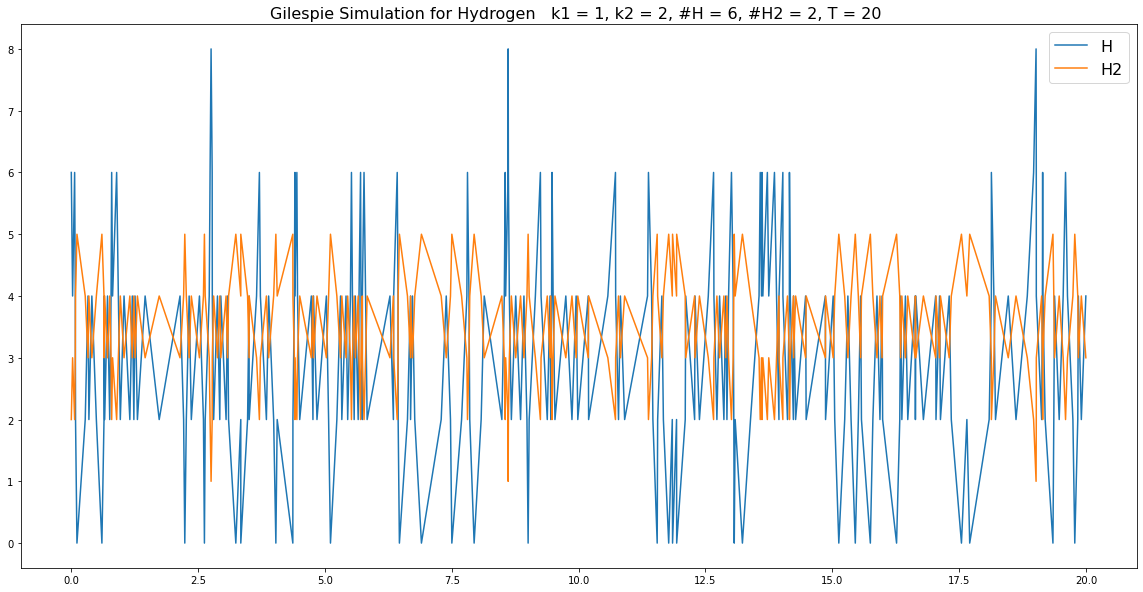

In [51]:
plt.figure(figsize=(20,10))
plt.plot(t,x[:,0],label='H')
plt.plot(t,x[:,1],label='H2')
plt.legend()
plt.title("Gilespie Simulation for Hydrogen" + parameters2str())

In [52]:
observation = [Chemical_model.gilespie(X_init,T) for _ in range(n_observation)]

In [53]:
prior = Prior(
    log_pdf = lambda _ : 0,
    sampler = lambda : (np.random.uniform(*parameter_range)),
    theta_range = parameter_range
)

In [54]:
def log_likelihood(theta,observation):
    theta = np.array(theta)
    return sum([Chemical_model.log_likelihood(
            theta,x,r,t,T) for x,r,t in observation])
    

In [55]:
model = BayersianModel(
    prior = prior,
    observation = observation,
    log_likelyhood = log_likelihood)

computing posterior: 100%|██████████| 40000/40000 [03:25<00:00, 194.94it/s]


<AxesSubplot:title={'center':'the pdf for posterior'}>

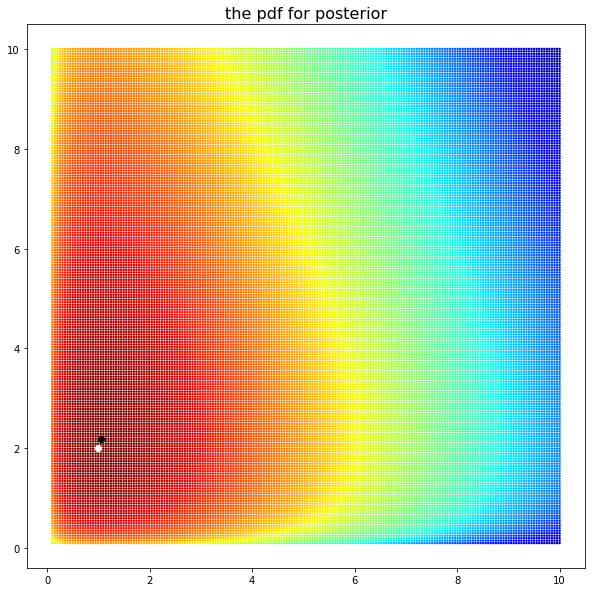

In [56]:
model.posterior_heatmap(true_theta=theta)

In [ ]:
assert(0)

$$
k_1(x)(x-1) = k_2(N-x)/2
$$

## inference

this inference is very slow because evaluating the log_posterior_proba is too expansive. 

In [57]:
mcmc = NaiveSampler(model=model)
posterior_samples = mcmc.simulation(theta_range='positive',box_size=box_size, n=int(5e4))

sampling posterior: 100%|██████████| 50100/50100 [04:18<00:00, 193.74it/s]

acceptance rate: 0.7303393213572854


## plot

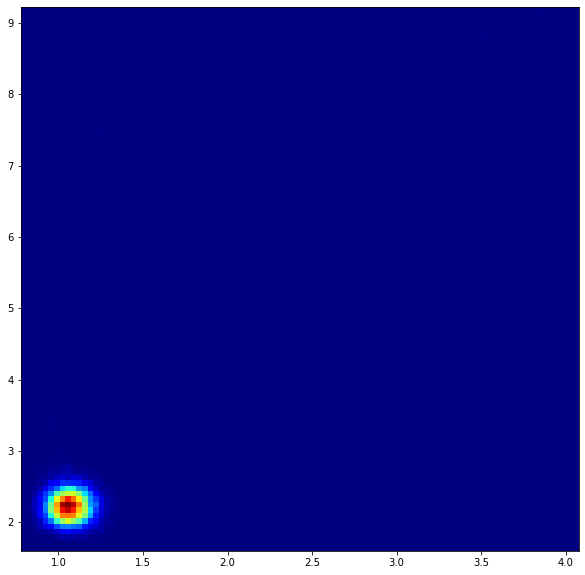

In [58]:
XX, YY = posterior_samples.T
plt.figure(figsize=(10,10))
ax = plt.hist2d(XX,YY,bins=(100,100),cmap='jet')
print()

In [59]:
import statsmodels.api as sm

ModuleNotFoundError: No module named 'statsmodels'

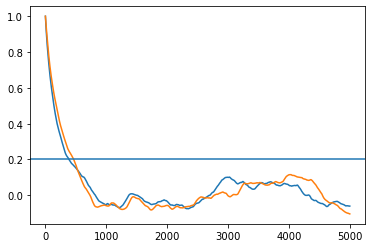

In [ ]:
plt.plot(sm.tsa.acf(posterior_samples[:,1],nlags=5000))
plt.plot(sm.tsa.acf(posterior_samples[:,0],nlags=5000))
# plt.xscale('log')
plt.axhline(0.2)


In [ ]:
tau = 2000

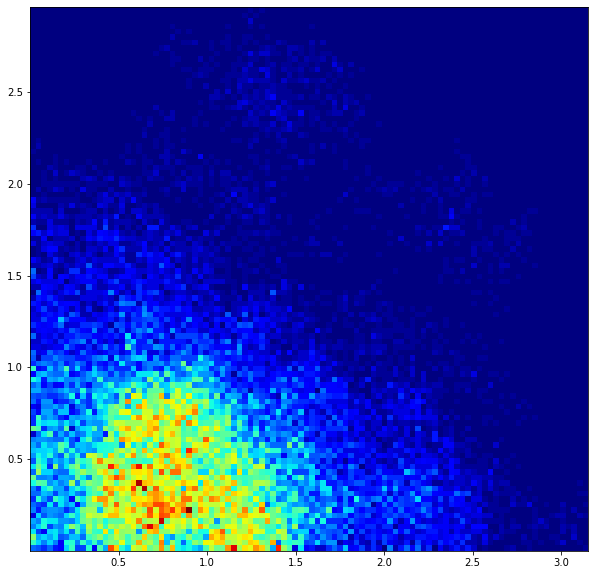

In [ ]:
XX, YY = posterior_samples[2*tau:].T
plt.figure(figsize=(10,10))
ax = plt.hist2d(XX,YY,bins=(100,100),cmap='jet')
print()

approximately $\tau \in [1000,3000]$, which means my effective samples is roughly 20-30... wow